# Use Qiskit to Teach Quantum Computing

## Contents

Preamble: IBM Quantum Lab environment

- Teach Quantum basics with Qiskit
    - Quantum Gates
    - Linear Algebra
- Teach Quantum backends with Qiskit
    - Simulators with Aer
    - Real Hardware
- Teach Quantum applications with Qiskit
    - Molecular simulation of H2 using Qiskit Nature
    - QNN with PyTorch using Qiskit Machine Learning

## Imports

In [20]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator, AerSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

# for quantum chem later
!pip install pyscf

ibmqfactory.load_account:WARNING:2022-08-03 14:33:07,579: Credentials are already in use. The existing account in the session will be replaced.


## Teach Quantum basics with Qiskit

### Circuit Drawer

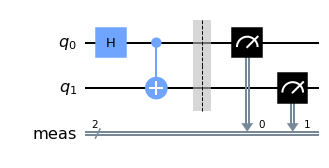

In [21]:
# Initialize quantum circuit
bell = QuantumCircuit(2)

# Apply gates
bell.h(0)
bell.cx(0,1)

# Measure qubits
bell.measure_all()

# Visualise circuit
bell.draw(output="mpl")

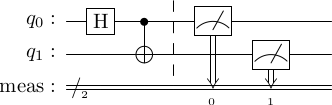

In [22]:
# other drawer options
bell.draw(output="latex")

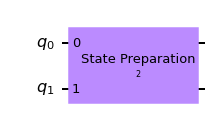

In [23]:
qc = QuantumCircuit(2)

# State Preparation
# qc2.prepare_state('01')
# qc2.prepare_state([0,1, 0, 0])
qc.prepare_state(2)

qc.draw()

### Tip! Use shift + tab to show docstring

In [24]:
from qiskit.quantum_info import Statevector

Statevector(qc).draw("latex")

<IPython.core.display.Latex object>

### Opflow module

In [25]:
from qiskit.opflow import I, X, Y, Z

my_hamiltonian = ((I^I)+(X^X)+(Y^Y)+(Z^Z))/2

print(my_hamiltonian)

0.5 * II
+ 0.5 * XX
+ 0.5 * YY
+ 0.5 * ZZ


In [26]:
print(my_hamiltonian.to_circuit())

global phase: 3.1429
       ┌───────────────┐            ┌──────────────────┐         »
q_0: ──┤ U3(π/2,π/2,0) ├────■───────┤ U3(π/2,-π/2,π/2) ├──────■──»
     ┌─┴───────────────┴─┐┌─┴─┐┌────┴──────────────────┴───┐┌─┴─┐»
q_1: ┤ U3(3.1403,π/2,-π) ├┤ X ├┤ U3(0.0018714,-3π/4,-3π/4) ├┤ X ├»
     └───────────────────┘└───┘└───────────────────────────┘└───┘»
«        ┌────────────────┐         ┌─────────────────┐ 
«q_0: ───┤ U3(π/2,0,-π/2) ├─────■───┤ U3(π/2,-π,-π/2) ├─
«     ┌──┴────────────────┴──┐┌─┴─┐┌┴─────────────────┴┐
«q_1: ┤ U3(1.5695,1.5695,-π) ├┤ X ├┤ U3(π/2,3.1403,-π) ├
«     └──────────────────────┘└───┘└───────────────────┘


In [27]:
print(my_hamiltonian.to_matrix())

[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]]


Other things: time evolutions, expectation values etc.

## Teach Quantum Backends with Qiskit

### Simulator Basics

In [28]:
# List simulators
Aer.backends()

[AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator_statevector'),
 AerSimulator('aer_simulator_density_matrix'),
 AerSimulator('aer_simulator_stabilizer'),
 AerSimulator('aer_simulator_matrix_product_state'),
 AerSimulator('aer_simulator_extended_stabilizer'),
 AerSimulator('aer_simulator_unitary'),
 AerSimulator('aer_simulator_superop'),
 QasmSimulator('qasm_simulator'),
 StatevectorSimulator('statevector_simulator'),
 UnitarySimulator('unitary_simulator'),
 PulseSimulator('pulse_simulator')]

In [29]:
# save statvector for later
bell.save_statevector()

# Statevector simulator
simulator = Aer.get_backend('aer_simulator_statevector')
circ = transpile(bell, simulator)

# Run and get counts
result = simulator.run(circ).result()
counts = result.get_counts(circ)

print(counts)

{'00': 532, '11': 492}


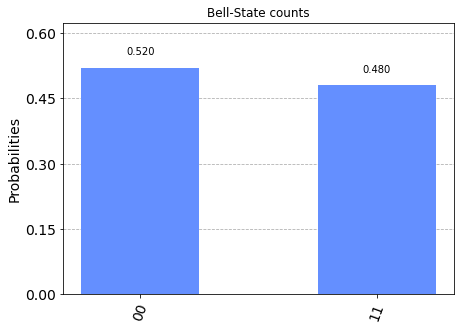

In [30]:
plot_histogram(counts, title='Bell-State counts') # let us plot a histogram to see the possible outcomes and corresponding probabilities

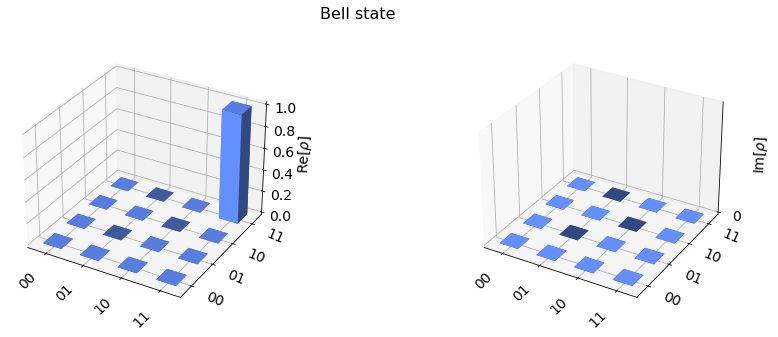

In [31]:
statevector = result.get_statevector(circ)
plot_state_city(statevector, title='Bell state')

### Mimic a noisy device with a Simulator

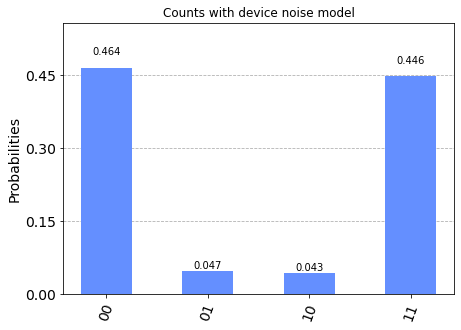

In [32]:
from qiskit.providers.fake_provider import FakeVigo

# Fetch a fake device and create a simulator backend object for it
fake_device = FakeVigo()
sim_vigo = AerSimulator.from_backend(fake_device)

# Transpile the circuit for the fake device simulator
tcirc = transpile(bell, sim_vigo)

# Execute noisy simulation and get counts
result_noise = sim_vigo.run(tcirc).result()
counts_noise = result_noise.get_counts(0)
plot_histogram(counts_noise,
               title="Counts with device noise model")

### Real Hardware!

In [33]:
from qiskit.providers.ibmq import least_busy

least_busy_device = least_busy(provider.backends(simulator=False, filters=lambda b: b.configuration().n_qubits >= 2))

least_busy_device

<IBMQBackend('ibmq_manila') from IBMQ(hub='ibm-q', group='open', project='main')>

Can run circuits on reald device same way as with simulators, but takes longer because of queue

## Teach Quantum applications with Qiskit

### Quantum Chemistry Applications

In [34]:
# Calculate Ground State Energy of H2
from qiskit_nature.drivers import UnitsType, Molecule
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureDriverType,
    ElectronicStructureMoleculeDriver,
)
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import JordanWignerMapper
from qiskit.utils import QuantumInstance
from qiskit_nature.algorithms import VQEUCCFactory
from qiskit_nature.algorithms import GroundStateEigensolver

molecule = Molecule(
    geometry=[["H", [0.0, 0.0, 0.0]], ["H", [0.0, 0.0, 0.735]]], charge=0, multiplicity=1
)
driver = ElectronicStructureMoleculeDriver(
    molecule, basis="sto3g", driver_type=ElectronicStructureDriverType.PYSCF
)

es_problem = ElectronicStructureProblem(driver)
qubit_converter = QubitConverter(JordanWignerMapper())

quantum_instance = QuantumInstance(backend=Aer.get_backend("aer_simulator_statevector"))
vqe_solver = VQEUCCFactory(quantum_instance=quantum_instance)

calc = GroundStateEigensolver(qubit_converter, vqe_solver)
res = calc.solve(es_problem)

print(res)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.857275030145
  - computed part:      -1.857275030145
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -1.137306035696
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.38894842]
    - computed part:      [0.0  0.0  1.38894842]
  > Dipole moment (a.u.): [0.0  0.0  0.00000028]  Total: 0.00000028
                 (debye): [0.0  0.0  0.00000072]  Total: 0.00000072
 


### Quantum Neural Network with PyTorch Connection

In [35]:
# Necessary imports

import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS

from qiskit import Aer, QuantumCircuit
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.opflow import AerPauliExpectation
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import CircuitQNN, TwoLayerQNN
from qiskit_machine_learning.connectors import TorchConnector

# Set seed for random generators
algorithm_globals.random_seed = 42

Accuracy: 0.45


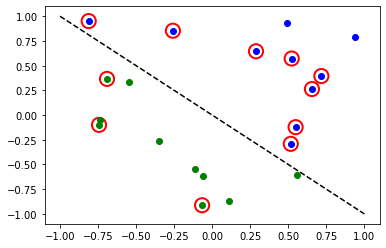

In [36]:
# declare quantum instance
qi = QuantumInstance(Aer.get_backend("aer_simulator_statevector"))

# Generate random dataset

# Select dataset dimension (num_inputs) and size (num_samples)
num_inputs = 2
num_samples = 20

# Generate random input coordinates (X) and binary labels (y)
X = 2 * algorithm_globals.random.random([num_samples, num_inputs]) - 1
y01 = 1 * (np.sum(X, axis=1) >= 0)  # in { 0,  1}, y01 will be used for CircuitQNN example
y = 2 * y01 - 1  # in {-1, +1}, y will be used for OplowQNN example

# Convert to torch Tensors
X_ = Tensor(X)
y01_ = Tensor(y01).reshape(len(y)).long()
y_ = Tensor(y).reshape(len(y), 1)

# Define feature map and ansatz
feature_map = ZZFeatureMap(num_inputs)
ansatz = RealAmplitudes(num_inputs, entanglement="linear", reps=1)

# Define quantum circuit of num_qubits = input dim
# Append feature map and ansatz
qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(ansatz, range(num_inputs))


# Define CircuitQNN and initial setup
parity = lambda x: "{:b}".format(x).count("1") % 2  # optional interpret function
output_shape = 2  # parity = 0, 1
qnn2 = CircuitQNN(
    qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    interpret=parity,
    output_shape=output_shape,
    quantum_instance=qi,
)

# Set up PyTorch module
# Reminder: If we don't explicitly declare the initial weights
# they are chosen uniformly at random from [-1, 1].
initial_weights = 0.1 * (2 * algorithm_globals.random.random(qnn2.num_weights) - 1)
model2 = TorchConnector(qnn2, initial_weights)

# Define model, optimizer, and loss
optimizer = LBFGS(model2.parameters()) # PyTorch optimiser
f_loss = CrossEntropyLoss()  # Our output will be in the [0,1] range

# Start training
model2.train()

# Define LBFGS closure method (explained in previous section)
def closure():
    optimizer.zero_grad(set_to_none=True)  # Initialize gradient
    loss = f_loss(model2(X_), y01_)  # Calculate loss
    loss.backward()  # Backward pass
    return loss


# Run optimizer (LBFGS requires closure)
optimizer.step(closure);

# Evaluate model and compute accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print("Accuracy:", sum(y_predict == y01) / len(y01))

# plot results
# red == wrongly classified
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

### Other things we don't have time for...
- Qiskit Runtime & Quantum Cloud
- Error Correction
- Algorithms (Shor's, Grover's, Phase Estimaiton, etc. etc.)
- Other applications (Machine Learning, Optimisation, Finance) --> Nick's session later!
- Pulse control & Dynamics (Lindblad equations) --> Nick's session later!
- Open Source!

https://qiskit.org/documentation


<div>
<img src="community_links.png" width="1400"/>
</div>